In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from scipy.signal import convolve2d
import cv2

In [43]:
img_source = Image.open(Path("./Dataset/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000155.jpg"))

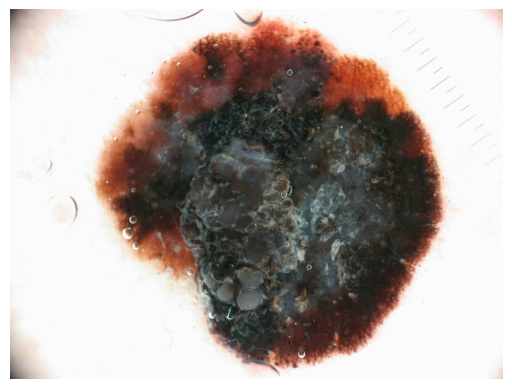

In [44]:
plt.imshow(img_source)
plt.axis("off")
plt.show()

In [45]:
def gaussian_kernel(ksize=5, sigma=1.0):
    """
    Membuat kernel Gaussian 2D.
    ksize: ukuran kernel (ganjil, misal 3,5,7,...)
    sigma: standar deviasi Gaussian
    """
    ax = np.arange(-ksize//2 + 1, ksize//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)   # normalisasi
    return kernel

def gaussian_filter(img, ksize=5, sigma=1.0):
    """
    Gaussian filter untuk noise reduction.
    img: citra numpy array (grayscale atau RGB)
    """
    kernel = gaussian_kernel(ksize, sigma)

    if img.ndim == 2:  # grayscale
        return convolve2d(img, kernel, mode='same', boundary='symm')

    elif img.ndim == 3:  # RGB
        filtered = np.zeros_like(img, dtype=float)
        for c in range(3):
            filtered[:, :, c] = convolve2d(img[:, :, c], kernel, mode='same', boundary='symm')
        return filtered

    else:
        raise ValueError("Format citra tidak dikenali.")    

img_source_arr = np.array(img_source)

img_source_filtered = gaussian_filter(img_source_arr)


In [46]:
# Ubah ke HSV
hsv = cv2.cvtColor(img_source_filtered.astype(np.uint8), cv2.COLOR_BGR2HSV)

# Ambil channel S saja (index 1)
s_channel = hsv[:, :, 1]

# Otsu pada S-channel ini
_, mask_s = cv2.threshold(s_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

Jumlah kontur terdeteksi setelah border dibersihkan: 2317


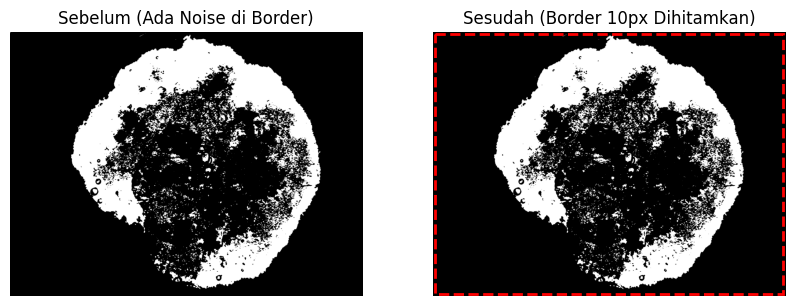

In [47]:
margin = 10 

mask_cleaned = mask_s.copy()

# Dapatkan dimensi gambar (Tinggi, Lebar)
h, w = mask_cleaned.shape[:2]

# Set border ATAS jadi hitam
# (Dari baris 0 sampai baris ke-'margin', selebar gambar)
mask_cleaned[0:margin, :] = 0

# Set border BAWAH jadi hitam
# (Dari tinggi minus 'margin' sampai habis, selebar gambar)
mask_cleaned[h-margin:h, :] = 0

# Set border KIRI jadi hitam
# (Sepanjang tinggi gambar, dari kolom 0 sampai 'margin')
mask_cleaned[:, 0:margin] = 0

# Set border KANAN jadi hitam
# (Sepanjang tinggi gambar, dari lebar minus 'margin' sampai habis)
mask_cleaned[:, w-margin:w] = 0

# --- Sekarang 'mask_cleaned' aman untuk findContours ---
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Jumlah kontur terdeteksi setelah border dibersihkan: {len(contours)}")

# --- Visualisasi ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Sebelum (Ada Noise di Border)")
plt.imshow(mask_s, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Sesudah (Border {margin}px Dihitamkan)")
plt.imshow(mask_cleaned, cmap='gray')
# Saya gambar kotak merah untuk menunjukkan area yang kita hitamkan paksa
plt.gca().add_patch(plt.Rectangle((margin, margin), w-2*margin, h-2*margin, 
                                  edgecolor='red', facecolor='none', lw=2, ls='--'))
plt.axis('off')

plt.show()

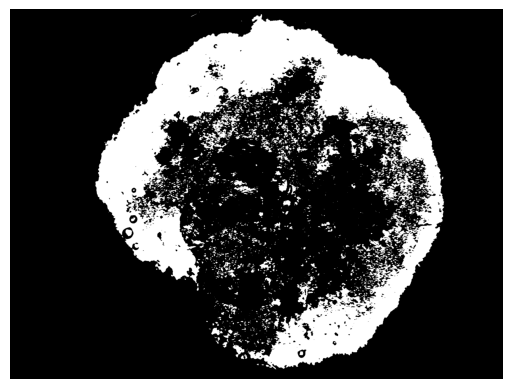

In [48]:
plt.imshow(mask_cleaned, cmap="gray")
plt.axis("off")
plt.show()

In [49]:
h, w = mask_cleaned.shape
border_thickness = 10

# Ambil potongan 4 sisi bingkai
top = mask_cleaned[0:border_thickness, :]
bottom = mask_cleaned[h-border_thickness:h, :]
left = mask_cleaned[:, 0:border_thickness]
right = mask_cleaned[:, w-border_thickness:w]

# Hitung rata-rata intensitas pixel di area bingkai tersebut
# Kita gabungkan nilai rata-rata dari keempat sisi
mean_border = (np.mean(top) + np.mean(bottom) + np.mean(left) + np.mean(right)) / 4.0

# Logika Penentuan
# Jika pinggiran dominan putih (> 127), berarti background terbalik
if mean_border > 127:
    mask_ready = cv2.bitwise_not(mask_cleaned) # Invert
    print("   -> Status: Inverted (Background detected as White)")
else:
    mask_ready = mask_cleaned # Normal
    print("   -> Status: Normal (Background detected as Black)")

   -> Status: Normal (Background detected as Black)


In [50]:
# ==========================================================
#  BAGIAN BARU: CEK SOLIDITAS (PENANGANAN EFEK DONAT)
# ==========================================================

# 1. Hitung kontur sementara dari mask yang sudah siap
temp_contours, _ = cv2.findContours(mask_ready, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Default: anggap tidak perlu perbaikan berat
mask_processed = mask_ready 

if len(temp_contours) > 0:
    # Ambil kontur terbesar (asumsi itu lesi)
    c_max = max(temp_contours, key=cv2.contourArea)
    
    # Hitung Area Lesi
    area = cv2.contourArea(c_max)
    
    # Hitung Area Convex Hull (Karet gelang yang membungkus lesi)
    hull = cv2.convexHull(c_max)
    hull_area = cv2.contourArea(hull)
    
    # Hitung Soliditas (Rasio Kepadatan)
    solidity = 0
    if hull_area > 0:
        solidity = area / hull_area
    
    # Debugging print (opsional, biar tahu nilai soliditasnya)
    # print(f"   -> Solidity: {solidity:.3f}")

    # JIKA SOLIDITAS RENDAH (< 0.75), BERARTI BOLONG/PECAH
    if solidity < 0.75:
        # print("   -> Terdeteksi bentuk donat/pecah. Melakukan patching...")
        
        # Lakukan Closing Agresif (Dilasi lalu Erosi)
        # Kernel 25x25 cukup besar untuk menutup lubang di tengah lesi
        kernel_fix = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
        mask_processed = cv2.morphologyEx(mask_ready, cv2.MORPH_DILATE, kernel_fix)

Sukses! Kontur terbesar dengan luas 1502780.5 pixel telah diisi.


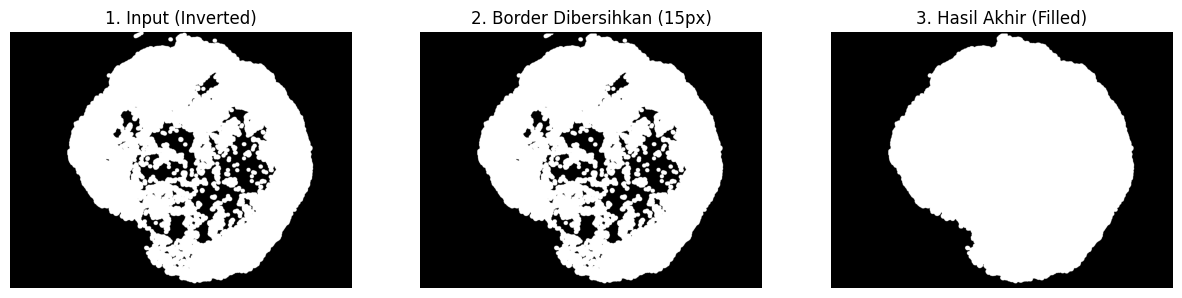

In [51]:
# Kita timpa pinggiran gambar dengan warna hitam (0) agar tidak mengganggu deteksi kontur
h, w = mask_processed.shape
margin = 15  # Atur ketebalan border yang mau dihapus (pixel)

# Copy agar aman
mask_clean = mask_processed.copy()
mask_clean[0:margin, :] = 0      # Atas
mask_clean[h-margin:h, :] = 0    # Bawah
mask_clean[:, 0:margin] = 0      # Kiri
mask_clean[:, w-margin:w] = 0    # Kanan

# --- 4. Cari Kontur Terluar ---
# RETR_EXTERNAL = Kunci ajaib! Dia mengabaikan lubang di dalam objek.
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Siapkan kanvas kosong untuk hasil akhir
final_result = np.zeros_like(mask_clean)

if len(contours) > 0:
    # Ambil kontur terbesar (berdasarkan area) untuk membuang noise kecil (jika ada)
    c_max = max(contours, key=cv2.contourArea)
    
    # --- 5. Gambar Ulang dengan Isian Penuh ---
    # thickness = -1 (atau cv2.FILLED) artinya "warnai isinya sampai penuh"
    cv2.drawContours(final_result, [c_max], -1, 255, thickness=cv2.FILLED)
    
    print(f"Sukses! Kontur terbesar dengan luas {cv2.contourArea(c_max)} pixel telah diisi.")
else:
    print("Error: Tidak ada kontur yang ditemukan setelah border dibersihkan.")

# --- Visualisasi Proses ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("1. Input (Inverted)")
plt.imshow(mask_processed, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"2. Border Dibersihkan ({margin}px)")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("3. Hasil Akhir (Filled)")
plt.imshow(final_result, cmap='gray')
plt.axis('off')

plt.show()